In [1]:
import xarray as xr
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from pyschism.mesh import Hgrid, Vgrid


def inverse_distance_weights(distances: np.ndarray, power: float = 1.0) -> np.ndarray:
    safe_distances = np.maximum(distances, 1e-6)
    weights = 1.0 / np.power(safe_distances, power)
    return weights / weights.sum(axis=1, keepdims=True)

class NearestSpatialLocator:
    def __init__(self, x_coords: np.ndarray, y_coords: np.ndarray) -> None:
        self.tree = KDTree(np.column_stack((x_coords, y_coords)))

    def query(self, lon: np.ndarray, lat: np.ndarray, k: int = 3) -> tuple[np.ndarray, np.ndarray]:
        points = np.column_stack((lon, lat))
        return self.tree.query(points, k=k)

def create_transect_file(start_coords, end_coords, step_degrees, filename="transect.bp"):
    lon1, lat1 = start_coords
    lon2, lat2 = end_coords
    total_dist = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2)
    num_points = int(np.ceil(total_dist / step_degrees)) + 1
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)
    with open(filename, 'w') as f:
        f.write(f"{num_points}\n")
        for i in range(num_points):
            f.write(f"{i+1} {lons[i]:.6f} {lats[i]:.6f} 1\n")

def interpolate_nodal_data(data_1d: np.ndarray, neighbor_indices: np.ndarray, idw_weights: np.ndarray) -> np.ndarray:
    """Interpolates 1D nodal data (e.g., depth, lat) onto transect points."""
    flat_indices = neighbor_indices.flatten()
    selected_data_1d = data_1d[flat_indices]
    selected_data = np.reshape(selected_data_1d, neighbor_indices.shape)
    
    weighted_data = selected_data * idw_weights
    
    if weighted_data.ndim == 1:
        return weighted_data  # k=1 case
    else:
        return np.sum(weighted_data, axis=1)  # k>1 case

def build_vertical_profile(data_source: xr.DataArray or np.ndarray,
                           vertical_layers: np.ndarray,
                           neighbor_indices: np.ndarray,
                           idw_weights: np.ndarray,
                           timestep: int = None) -> np.ndarray:
    """Builds a 2D vertical profile by interpolating data layer by layer."""
    profile_layers = []
    for z in vertical_layers:
        if timestep is not None and isinstance(data_source, xr.DataArray):
            layer_data = data_source[timestep, :, z].values
        else:
            layer_data = data_source[:, z]

        interpolated_layer = interpolate_nodal_data(layer_data, neighbor_indices, idw_weights)
        profile_layers.append(interpolated_layer)
    
    return np.array(profile_layers)

C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG = {
    "base_path": r"C:\Users\Felicio.Cassalho\Work\Literature\AK_Paper_01\Figures\extra_materials\vertical_prof/",
    "transect_start": (185.00, 51.50),
    "transect_end": (185.00, 53.50),
    "transect_step_deg": 0.02,
    "transect_filename": "transect.bp",
    "k_neighbors": 1,
    "variable_to_plot": "temperature",  # Change to "salinity", etc.
    "timestep_to_plot": 0,
    "plot_vmin": 3,
    "plot_vmax": 6,
    "plot_depth_limit": 600
}

In [3]:
# 2 SETUP
create_transect_file(CONFIG["transect_start"], CONFIG["transect_end"], CONFIG["transect_step_deg"], CONFIG["transect_filename"])
bp = np.loadtxt(CONFIG["transect_filename"], delimiter=' ', skiprows=1)
bpx, bpy = bp[:, 1], bp[:, 2]

✅ Successfully created 'transect.bp' with 101 points.


In [4]:
# 3 LOAD MODEL GRID & DATA
hgrid_path = f'{CONFIG["base_path"]}/hgrid.gr3'
vgrid_path = f'{CONFIG["base_path"]}/vgrid.in'
# NOTE: Assumes model output file is named like 'temperature_0.nc'
model_output_path = f'{CONFIG["base_path"]}/outputs/{CONFIG["variable_to_plot"]}_{CONFIG["timestep_to_plot"]}.nc'

hgrid = Hgrid.open(hgrid_path, crs=4326)
vgrid = Vgrid.open(vgrid_path)
model_output = xr.open_dataset(model_output_path)

# Extract the main data variable dynamically
data_variable = model_output[CONFIG["variable_to_plot"]]

In [54]:
# 4 SPATIAL INTERPOLATION SETUP
mesh_tree = NearestSpatialLocator(hgrid.x, hgrid.y)
nodes_weight, nodes_query = mesh_tree.query(bpx, bpy, k=CONFIG["k_neighbors"])
idw = inverse_distance_weights(nodes_weight) if CONFIG["k_neighbors"] > 1 else np.ones_like(nodes_weight)

In [55]:
# 5 INTERPOLATE DATA TO TRANSECT

final_depth_values = interpolate_nodal_data(hgrid.values, nodes_query, idw)
final_lat_values = interpolate_nodal_data(hgrid.y, nodes_query, idw)

vertical_layers_indices = np.flip(np.arange(data_variable.shape[-1]))
profile = build_vertical_profile(data_variable, vertical_layers_indices, nodes_query, idw, timestep=CONFIG["timestep_to_plot"])
profile_sig = build_vertical_profile(vgrid.sigma, vertical_layers_indices, nodes_query, idw)
scaled_profile = profile_sig * final_depth_values

In [56]:
# 6 DATA CLEANING FOR PLOTTING 
# (This section remains the same)
invalid_coords_mask = np.isnan(scaled_profile)
scaled_profile_cleaned = scaled_profile.copy()
profile_cleaned = profile.copy()
profile_cleaned[invalid_coords_mask] = np.nan
scaled_profile_cleaned[invalid_coords_mask] = 0

In [77]:
from matplotlib.colors import BoundaryNorm
levels = np.arange(3, 6.01, 0.1)
cmap = plt.get_cmap('turbo') # Get the colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

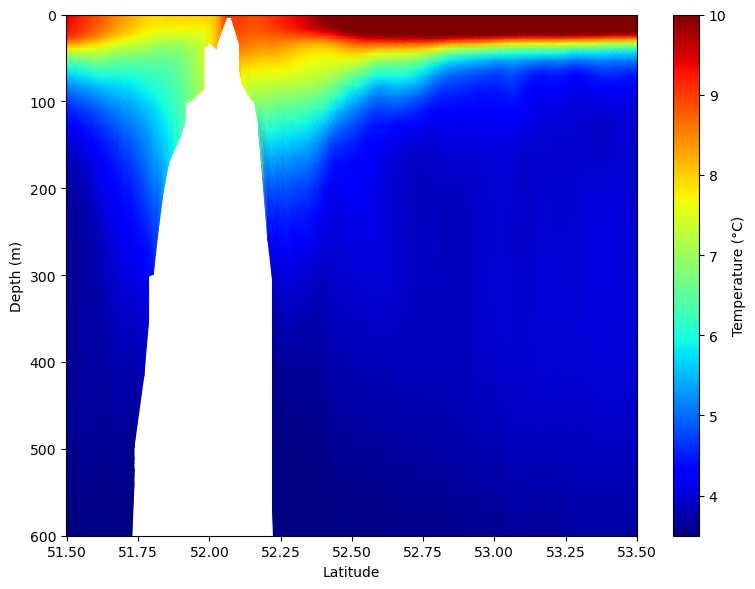

In [106]:
# 7 PLOTTING
plt.figure(figsize=(8, 6))
plt.pcolormesh(final_lat_values, scaled_profile_cleaned, profile_cleaned,
               shading='gouraud', 
               # cmap=cmap, norm=norm)
               cmap='jet', vmin=3.5, vmax=10)
plt.colorbar(label=f'{CONFIG["variable_to_plot"].capitalize()} (°C)')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
# plt.title(f'{CONFIG["variable_to_plot"].capitalize()} Profile (Timestep: {CONFIG["timestep_to_plot"]})')
plt.gca().invert_yaxis()
plt.ylim(CONFIG["plot_depth_limit"], 0)
plt.tight_layout()
plt.savefig("temp.jpeg")
plt.show()

### Salinity:

In [58]:
model_output_path_salt = f'{CONFIG["base_path"]}/outputs/salinity_{CONFIG["timestep_to_plot"]}.nc'
model_output_salt = xr.open_dataset(model_output_path_salt)
data_variable_salt = model_output_salt['salinity']

In [59]:
profile_salt = build_vertical_profile(data_variable_salt, vertical_layers_indices, nodes_query, idw, timestep=CONFIG["timestep_to_plot"])
profile_sig_salt = build_vertical_profile(vgrid.sigma, vertical_layers_indices, nodes_query, idw)
scaled_profile_salt = profile_sig_salt * final_depth_values

In [60]:
invalid_coords_mask_salt = np.isnan(scaled_profile_salt)
scaled_profile_cleaned_salt = scaled_profile_salt.copy()
profile_cleaned_salt = profile_salt.copy()
profile_cleaned_salt[invalid_coords_mask_salt] = np.nan
scaled_profile_cleaned_salt[invalid_coords_mask_salt] = 0

In [90]:
from matplotlib.colors import BoundaryNorm
levels = np.arange(32.5, 34.1, 0.2)
cmap = plt.get_cmap('turbo') # Get the colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

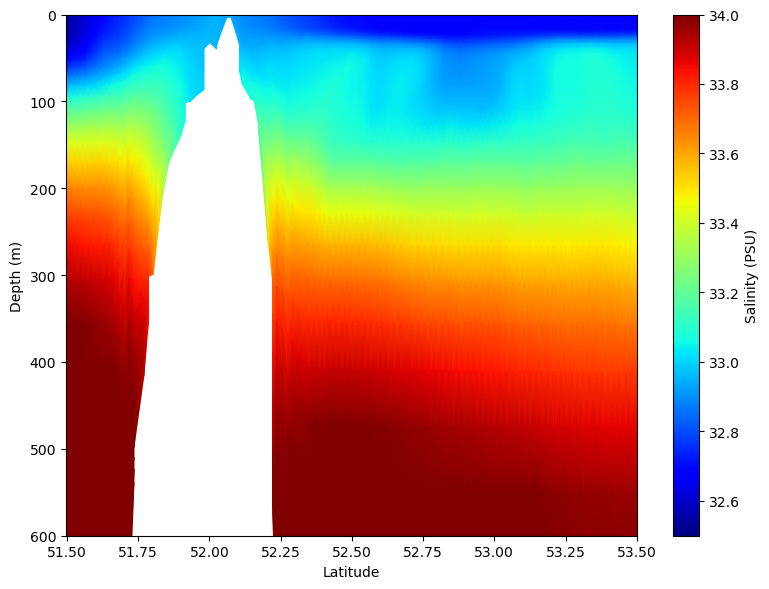

In [92]:
# 7 PLOTTING 
plt.figure(figsize=(8, 6))
plt.pcolormesh(final_lat_values, scaled_profile_cleaned_salt, profile_cleaned_salt,
               # shading='gouraud',cmap=cmap, norm=norm)
               shading='gouraud', cmap='jet', vmin=32.5, vmax=34)
plt.colorbar(label=f'Salinity (PSU)')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
# plt.title(f'{CONFIG["variable_to_plot"].capitalize()} Profile (Timestep: {CONFIG["timestep_to_plot"]})')
plt.gca().invert_yaxis()
plt.ylim(CONFIG["plot_depth_limit"], 0)
plt.tight_layout()
plt.savefig("salt.jpeg")
plt.show()

## Water Density

In [62]:
import seawater as sw
import numpy.ma as ma

In [63]:
density = sw.dens(profile_cleaned_salt, profile_cleaned) - 1000

In [64]:
density_masked = ma.masked_invalid(density)

In [95]:
from matplotlib.colors import BoundaryNorm
levels = np.arange(25, 27.01, 0.2)
cmap = plt.get_cmap('turbo') # Get the colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

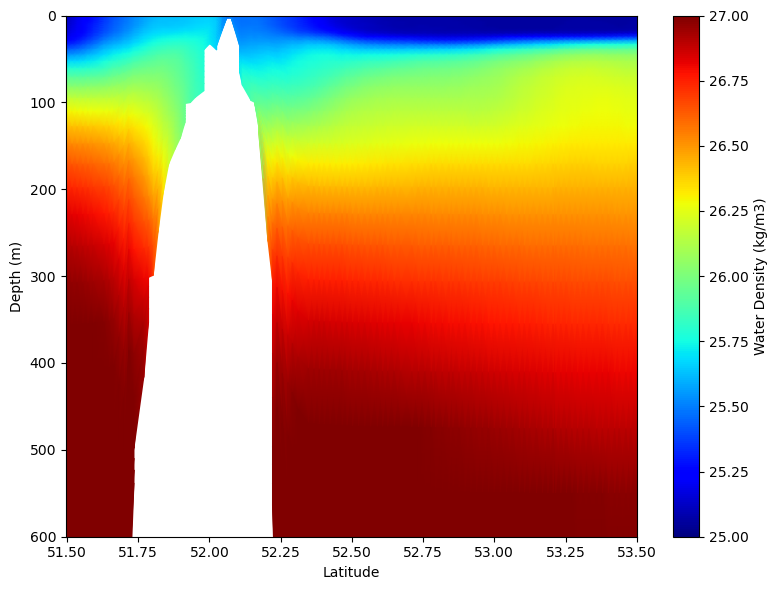

In [100]:
# 7 PLOTTING
isoline_levels = [25.0, 25.5, 26.0, 26.5, 27.0]

plt.figure(figsize=(8, 6))
plt.pcolormesh(final_lat_values, scaled_profile_cleaned_salt, density,
               # shading='gouraud',cmap=cmap, norm=norm)
               shading='gouraud', cmap='jet', vmin=25, vmax=27)
plt.colorbar(label=f'Water Density (kg/m3)')


# isoline_levels = [25.0, 25.5, 26.0, 26.5,  26.8,27.0]
# CS = plt.contour(final_lat_values, depth_values, density,
#                  levels=isoline_levels, colors='black') # Using depth_values here
# plt.clabel(CS, inline=False, fontsize=10, fmt='%1.1f')

plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
# plt.title(f'{CONFIG["variable_to_plot"].capitalize()} Profile (Timestep: {CONFIG["timestep_to_plot"]})')
plt.gca().invert_yaxis()
plt.ylim(CONFIG["plot_depth_limit"], 0)
plt.tight_layout()
plt.savefig("dens.jpeg")
plt.show()